# Sentinel-1 products

This section shows the performance of MET Norway for Sentinel-1 products. Both, an overall status and last month status are shown below.

Note that scihub is no longer in operation but is included for historical comparisons.

In [1]:
import pathlib
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
from IPython.display import Markdown as md
import sys
import os

sys.path.append(os.path.abspath('../utils/'))
from shared_functions import plot_stats, plot_missing, hubs, plot_stats_simple, plot_stats_logs_daily, plot_stats_logs, read_dhus_logs, get_year_and_month, get_month_name

year, month = get_year_and_month()
month_name = get_month_name(month)

# Create start and end dates
start_date = pd.to_datetime(f'{year}-{month}-01')
end_date = pd.to_datetime(f'{year}-{month + 1}-01') - pd.Timedelta(days=1)  # Last day of the month

In [2]:
logsdir = pathlib.Path('../data')

In [3]:
data_FE = None
for h in hubs:
    csvfile = logsdir / f'products_in_{h}.csv'
    data_tmp = pd.read_csv(csvfile, header=None, names=['product', 'area', 'sensing_date', f'{h}'], parse_dates=['sensing_date'])
    # If several sensing date exist, keep the most recent one
    data_clean = copy.deepcopy(data_tmp.drop_duplicates(subset=['sensing_date', 'product', 'area'], keep='last'))
    if h == 'colhub_AOI':
        data_clean['area'] = 'colhub_aoi'
    if data_FE is None:
        data_FE = data_clean
    else:
        data_FE = data_FE.merge(data_clean, on=['sensing_date', 'product', 'area'], how='outer')

In [4]:
data = data_FE
data.set_index('sensing_date', inplace=True)
data.sort_index(inplace=True)
data.fillna(0, inplace=True)

# Filtering data
data = data[
    (data.index <= end_date)
]


## Products on portals

The following section contains an update on the Sentinel-1 products included in the different FEs and BEs.

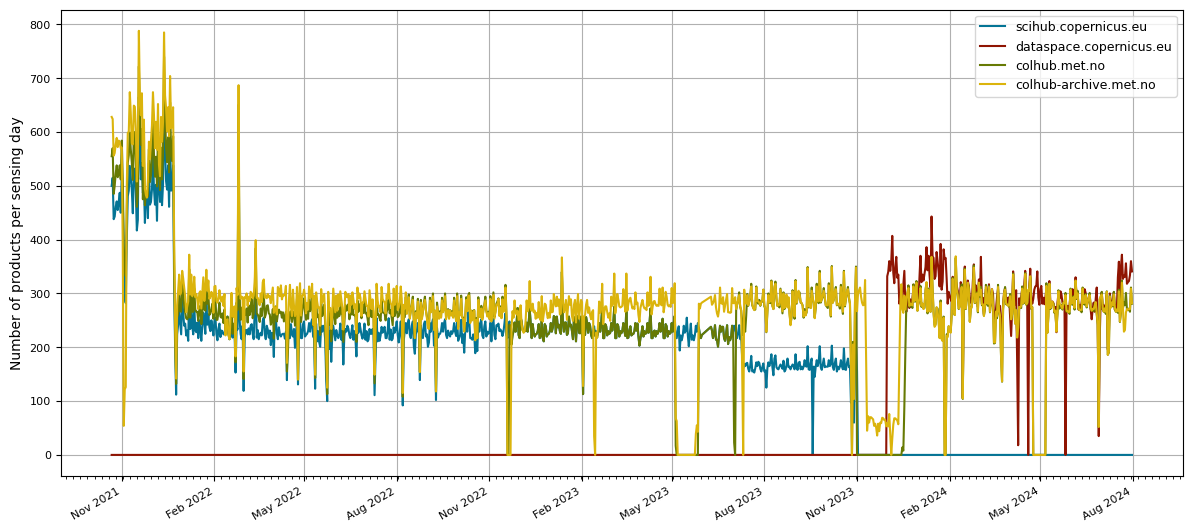

In [5]:
# Filtering data
filtered_data = data[
    (data['product'] == 'S1') & 
    (data['area'] == 'colhub_aoi')
]

plot_stats(filtered_data, plot_max = True)


The figure above represents the overall number of products present in the different BackEnds and FrontEnds per day for Sentinel-1.

While the figure below shows a zoom on the last month.

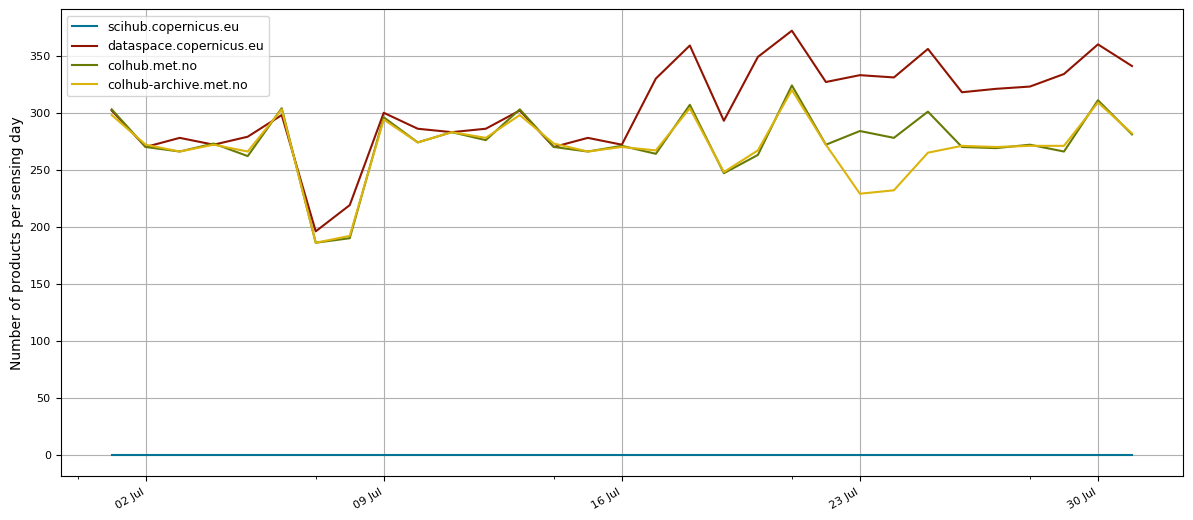

In [6]:
# Filtering data
filtered_data = data[
    (data.index >= start_date) & 
    (data.index <= end_date) & 
    (data['product'] == 'S1') & 
    (data['area'] == 'colhub_aoi')
]

plot_stats(filtered_data, plot_max = False)


A table is also included for more detailed information.

In [7]:
data_c = filtered_data[['colhub_global', 'cdse', 'colhub_AOI']].copy()
data_c.rename(inplace=True, columns={'colhub_global':'colhub.met.no', 'cdse': 'dataspace.copernicus.eu', 'colhub_AOI':'colhub-archive.met.no'})
data_c
# S1 colhub global FE has more data than esahub global FE and the BE as it contains the KSAT data

,colhub.met.no,dataspace.copernicus.eu,colhub-archive.met.no
sensing_date,,,
2024-07-01,303.0,302.0,298.0
2024-07-02,270.0,270.0,272.0
2024-07-03,266.0,278.0,266.0
2024-07-04,273.0,272.0,272.0
2024-07-05,262.0,279.0,266.0
2024-07-06,304.0,298.0,303.0
2024-07-07,186.0,196.0,186.0
2024-07-08,190.0,219.0,192.0
2024-07-09,296.0,300.0,294.0


## Missing products

In [8]:
# Number of missing products
total_all = int(sum(data['cdse']))
missing_all = int(sum(data['cdse'] - data['colhub_AOI']))
included_perc_all = int(sum(data['colhub_global'])/sum(data['cdse']))*100
missing_perc_all = 100 - included_perc_all

filtered_data = data[
    (data.index >= start_date) & 
    (data.index <= end_date)
]

total_month = int(sum(filtered_data['cdse']))
missing_month = int(sum(filtered_data['cdse'] - filtered_data['colhub_AOI']))
included_perc_month = int(sum(filtered_data['colhub_AOI'])/sum(filtered_data['cdse']))*100
missing_perc_month = 100 - included_perc_month


In [9]:
md("The overall total number of Sentinel-1 products is {}. The number of overall Sentinel-1 missing products consists of {} images. This represents that a {}% of the total was included in MET Norway DHR, while a {}% was not included.".format(total_all, missing_all, included_perc_all, missing_perc_all))

The overall total number of Sentinel-1 products is 5073529. The number of overall Sentinel-1 missing products consists of 2096966 images. This represents that a 600% of the total was included in MET Norway DHR, while a -500% was not included.

In [10]:
md(f"The total number of Sentinel-1 products in {month_name} is {total_month}. The number of Sentinel-1 missing products during {month_name} consists of {missing_month} images. This represents that a {included_perc_month}% of the total was included in MET Norway DHR, while a {missing_perc_month}% was not included.")

The total number of Sentinel-1 products in July is 1064250. The number of Sentinel-1 missing products during July consists of 921413 images. This represents that a 0% of the total was included in MET Norway DHR, while a 100% was not included.

## Data ingestion

In this section the time difference between sensing time and ingestion time at MET Norway is assessed. The ingestion time is the time at which a Sentinel product was downloaded to MET Norway BE and so, it is automatically available in at least one of the MET Norway FEs.

In [11]:
csvdir = logsdir

/home/lukem/Documents/MET/Projects/ESA_NBS/Git_repos/NBS_monthly_reports/utils/shared_functions.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_1 = d.groupby(['day']).sum()[['size', 'number']]
/home/lukem/Documents/MET/Projects/ESA_NBS/Git_repos/NBS_monthly_reports/utils/shared_functions.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_1 = d.groupby(['day']).sum()[['size', 'number']]
/home/lukem/Documents/MET/Projects/ESA_NBS/Git_repos/NBS_monthly_reports/utils/shared_functions.py:90: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future versi

Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 1123 ticks ([18864.0, ..., 19986.0]), which exceeds Locator.MAXTICKS (1000).


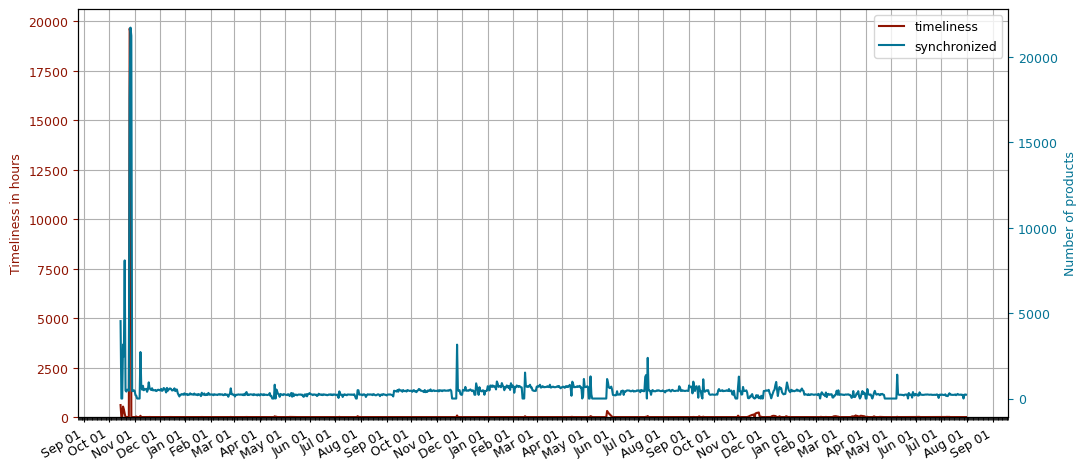

In [12]:
data = read_dhus_logs(csvdir / 'S1-backend-AOI_inputs.csv')
for key, df in data.items():
    filtered_df = df[
        (df.index <= end_date)
    ]
    data[key] = filtered_df
plot_stats_logs(data['synchronized'], plot_max=True)

The figure above shows an overall status of the Sentinel-1 synchronization between ESA datahub and MET Norway BE. The number of products synchronized and deleted are represented by the dark and light blue lines respectively. The red line represents the timeliness.

Following previous sections, the graph below shows a zoom in the last month for the synchronization between ESA datahub and MET Norway BE.

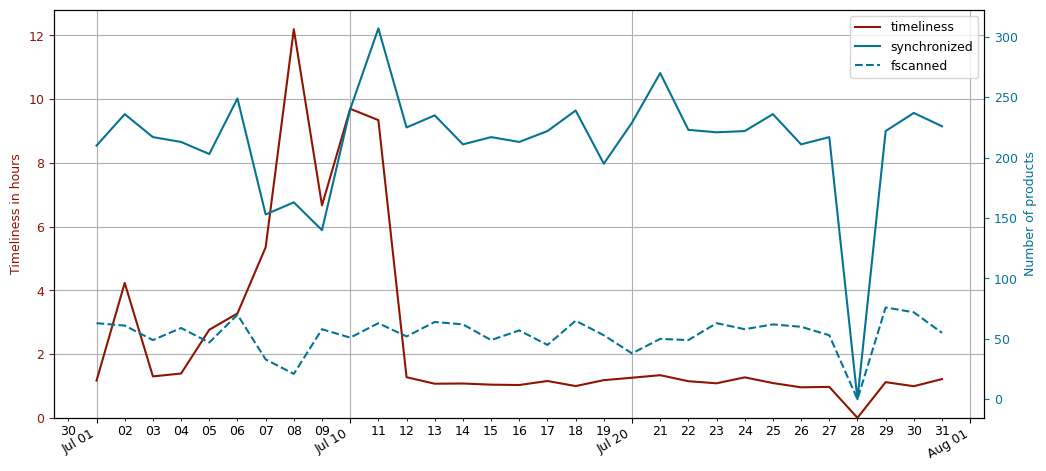

In [13]:
filtered_synchronized = data['synchronized'][
    (data['synchronized'].index >= start_date) & 
    (data['synchronized'].index <= end_date) 
]
filtered_fscanner = data['fscanner'][
    (data['fscanner'].index >= start_date) & 
    (data['fscanner'].index <= end_date) 
]

plot_stats_logs_daily(filtered_synchronized, fscanner=filtered_fscanner, plot_max=False)

A more detailed information is given in the table below where the last month is assessed for products synchronized from ESA.

In [14]:
#print('Numbers for the last 5 days')
filtered_synchronized

,size,number,timeliness
day,,,
2024-07-01,510.920343,210,1.169281
2024-07-02,594.302595,236,4.233536
2024-07-03,482.808090,217,1.300325
2024-07-04,544.839277,213,1.390762
2024-07-05,470.561127,203,2.763810
2024-07-06,608.149567,249,3.276922
2024-07-07,352.885969,153,5.351882
2024-07-08,387.004046,163,12.195025
2024-07-09,342.550666,140,6.668906


It is also given extra information in the table below where the data are assessed for products synchronized from KSAT.

In [15]:
filtered_fscanner

,size,number,timeliness
day,,,
2024-07-01,61.674723,63,0.748754
2024-07-02,74.663372,61,0.687588
2024-07-03,47.981751,49,0.586646
2024-07-04,66.348442,59,0.713529
2024-07-05,47.123828,47,0.694620
2024-07-06,67.815843,70,0.677592
2024-07-07,47.121044,33,0.682181
2024-07-08,30.590162,21,1.002695
2024-07-09,70.575044,58,0.799586
